# Macroeconomic event trading

In this section, we describe trading around specific scheduled macroeconomic events. 

## Macroeconomic events

In [1]:
# hide
from IPython.display import Image, display

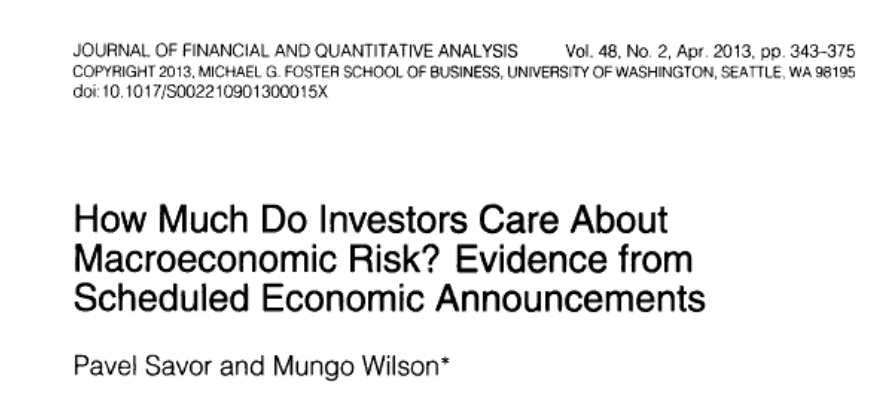

In [2]:
# hide
display(Image("images/savor_title.png", width=600))

Three statements in Savor and Wilson (2013): 

- U.S. stock market returns are significantly higher on days when important macroeconomic news is scheduled to be announced.
- Inversely, the returns on T-Bills is significantly lower on these days.
- The announcement surprises do not seem to predict the returns. 

These facts are consistent with risk-averse investors demanding higher return for holding event risk. 

Data: 

- 157 prescheduled CPI announcements from Jan. 1958 to Jan. 1971 and 467 for the PPI from Feb. 1971 to Dec. 2009. 
- 621 employment announcements from Jan. 1958 to Dec. 2009. 
-  FOMC interest rate announcements start in Jan. 1978 and end in Dec. 2009. 

Any unscheduled announcements are excluded, leaving us with 279 FOMC observations.

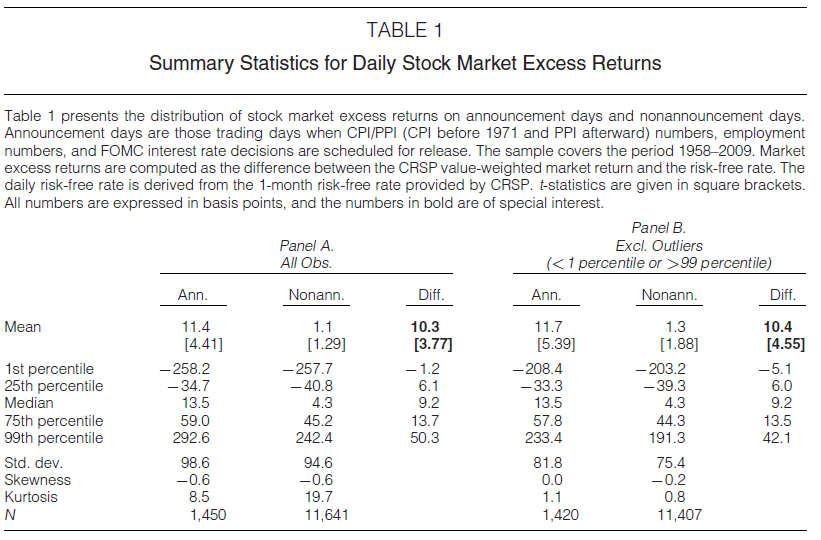

In [3]:
# hide
display(Image("images/l6_savor_1.PNG", width=500))

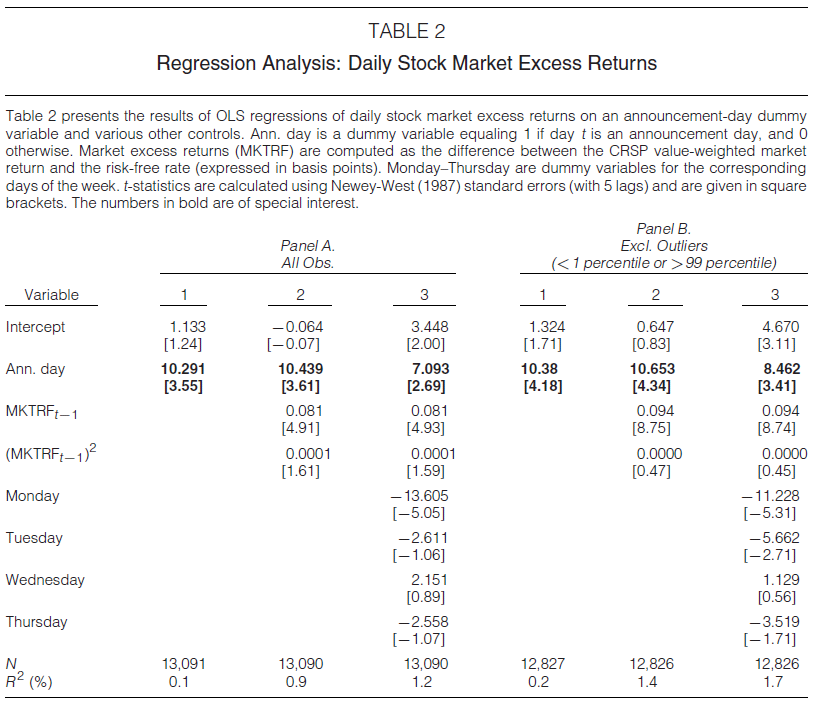

In [4]:
# hide
display(Image("images/l6_savor_2.PNG", width=500))

The return (resp. standard deviation) is 11.4bps (resp. 98.6 bps) on announcement days and 1.1bps (resp. 94.6 bps) on non-announcement days, so that the annualized Sharpe ratios very different, 1.8 and .18 respectively. The next two figures show similar statements (with inverse sign) for the risk-free asset (= T-Bills) -- impacted by precautionary saving demand.

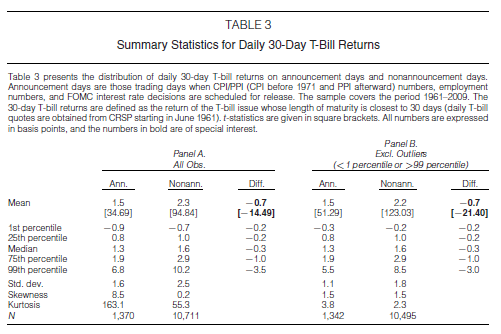

In [5]:
# hide
display(Image("images/savorWilsonTable3.PNG", width=500))

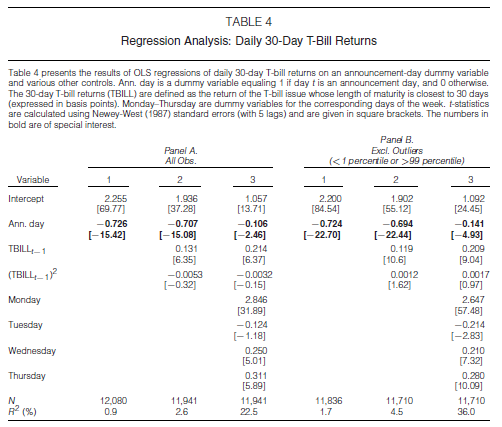

In [6]:
# hide
display(Image("images/savorWilsonTable4.PNG", width=500))

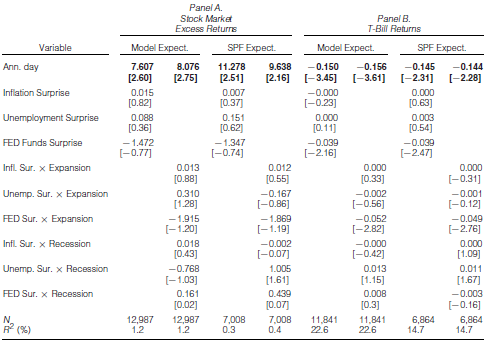

In [7]:
# hide
display(Image("images/savorWilsonTable5.PNG", width=500))

Other events from the follow-up paper: Savor and Wilson (2014): ``Asset pricing: a Tale of Two Days," 

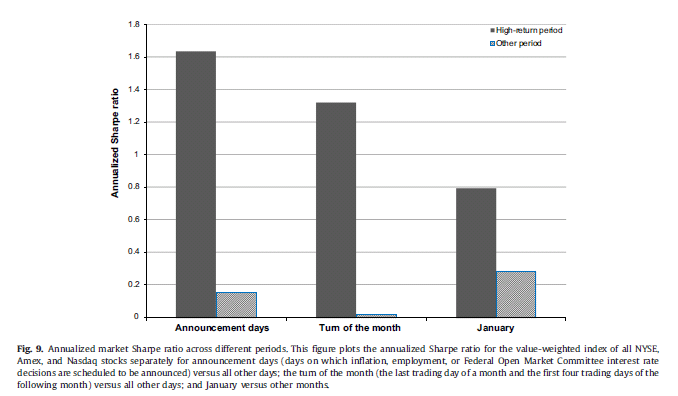

In [8]:
# hide
display(Image("images/l6_savor_3.PNG", width=500))

## FOMC dates

The Federal Open Market Committee (FOMC) is a component of the Federal Reserve System, responsible for overseeing the country's open market operations and essentially setting U.S. monetary policy. The FOMC makes key decisions regarding interest rates and the growth of the United States money supply, influencing economic activity, employment, and inflation.

FOMC statements are important for financial markets because they provide insights into the committee's economic outlook and monetary policy intentions. Investors, analysts, and economists closely examine these statements for clues about the future direction of interest rates and other policy measures. Any changes or signals in the FOMC's approach can lead to significant movements in financial markets, affecting everything from stock prices and bond yields to currency exchange rates and commodity prices.

In this section, in this section, we focus only on the dates when statements are released -- ignoring what was said in the statement. We will cover later how to extract information from these statements. 

In [9]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
from IPython.display import Image
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

In [10]:
from skfin.datasets_ import load_fomc_statements
from skfin.plot import bar, line
from skfin.text import show_text

In [11]:
statements = load_fomc_statements(force_reload=False)

INFO:skfin.dataloaders.cache:Loading from cache : data/fomc_statements.parquet


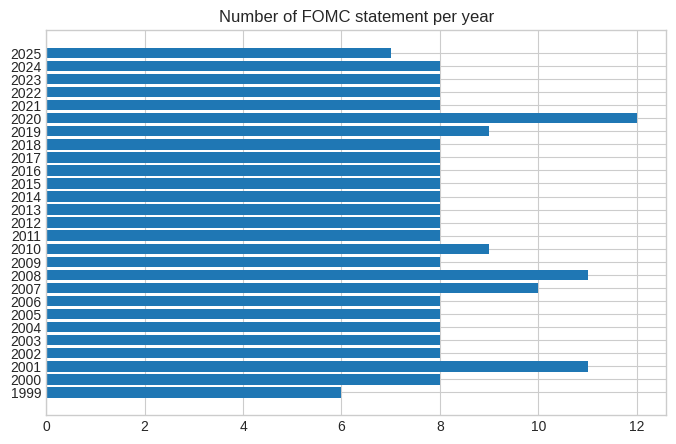

In [12]:
bar(
    statements.groupby(lambda x: x.year)["text"].count(),
    sort=False,
    horizontal=True,
    title="Number of FOMC statement per year",
)

## Returns on statement days

In [13]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import BDay
from skfin.datasets_ import load_kf_returns

ret = load_kf_returns(filename="F-F_Research_Data_Factors_daily")["Daily"]

INFO:skfin.dataloaders.cache:Loading from cache : data/F-F_Research_Data_Factors_daily


In [14]:
ret_norm = ret.div(ret.ewm(halflife=252).std())[
    statements.sort_index().index[0] :
].asfreq("B")

Some FOMC meetings on Sundays or when the markets are closed: 

- '2008-01-21': Luther King Jr Day 
- '2010-05-09': Sunday 
- '2020-03-15': (note the release time!!!)

In [15]:
special_days = ["2008-01-22", "2010-05-09", "2020-03-15"]
idx0 = pd.to_datetime(pd.Index(special_days))
idx = statements.index.difference(idx0).union(idx0 + BDay(1))

In [16]:
ret_fomc = pd.concat(
    {
        "fomc": ret_norm.loc[ret_norm.index.intersection(idx)],
        "not fomc": ret_norm.loc[ret_norm.index.difference(idx)],
    },
    axis=1,
)

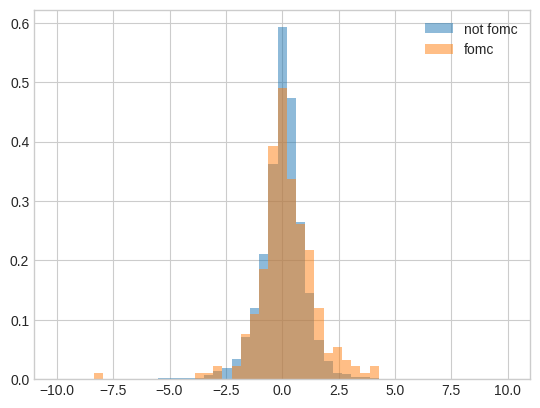

In [17]:
bins = np.linspace(-10, 10, 50)
plt.hist(
    ret_fomc["not fomc"]["Mkt-RF"].dropna(),
    bins,
    density=True,
    alpha=0.5,
    label="not fomc",
)
plt.hist(
    ret_fomc["fomc"]["Mkt-RF"].dropna(), bins, density=True, alpha=0.5, label="fomc"
)
plt.legend(loc="upper right")
plt.show()

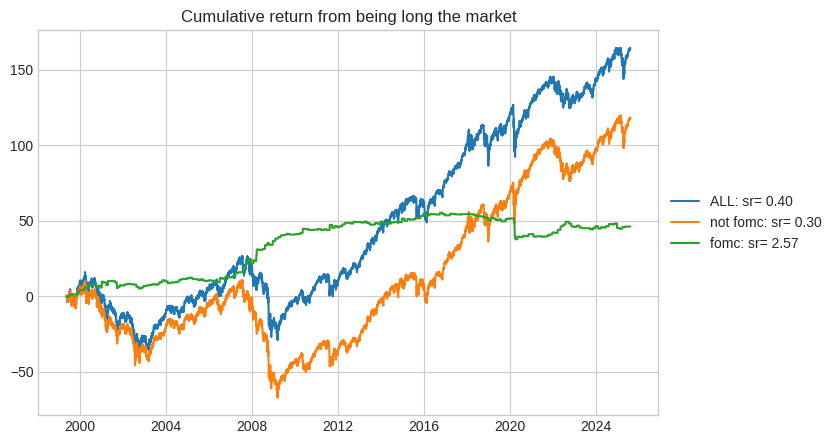

In [18]:
line(
    ret_fomc.xs("Mkt-RF", axis=1, level=1)
    .fillna(0)
    .assign(ALL=lambda x: x.sum(axis=1))["1996":],
    cumsum=True,
    title="Cumulative return from being long the market",
)

In [19]:
ret_fomc.std().unstack().round(2)

,Mkt-RF,SMB,HML,RF
fomc,1.28,1.08,1.25,2.39
not fomc,0.98,1.00,1.01,2.43


In [20]:
from skfin.metrics import sharpe_ratio

In [21]:
ret_fomc.pipe(sharpe_ratio).unstack().round(2)

,Mkt-RF,SMB,HML,RF
fomc,2.57,1.91,-0.56,21.31
not fomc,0.30,0.06,0.00,20.52


In [22]:
ret_fomc.clip(lower=-3, upper=3).pipe(sharpe_ratio).unstack().round(2)

,Mkt-RF,SMB,HML,RF
fomc,3.11,1.85,-0.65,68.38
not fomc,0.37,0.08,-0.09,68.73


In [23]:
ret_fomc.drop(pd.to_datetime("2020-03-16")).asfreq("B").pipe(
    sharpe_ratio
).unstack().round(2)

,Mkt-RF,SMB,HML,RF
fomc,3.39,1.94,-0.49,21.27
not fomc,0.30,0.06,0.00,20.52
